# Optimization Reports

### Imports

In [116]:
import json
import time
import tracemalloc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import warnings
warnings.filterwarnings('ignore')

### Setup

In [117]:
# SpaCy model
nlp = spacy.load('en_core_web_sm')

In [118]:
# Load dataset
def load_dataset(path='../dataset/philippine-legal-dataset.json'):
    with open(path, 'r', encoding='utf-8') as f:
        dataset = json.load(f)
    return dataset

### Import Models

In [119]:
import os
import sys

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [120]:
# Models
from models.tfidf_cosine import TFIDFCosineSimilarity
from models.okapi_bm25 import BM25Similarity
from models.jaccard import JaccardSimilarity
from models.sbert import SentenceBERTSimilarity

### Run Evaluations

In [121]:
dataset = load_dataset()

In [158]:
from evaluation.metrics import evaluate_model

traditional_ablation_results = {
    "TF-IDF Raw": evaluate_model(TFIDFCosineSimilarity(use_preprocessing=False), dataset),
    "TF-IDF Preprocessed": evaluate_model(TFIDFCosineSimilarity(), dataset),
    "BM25 Raw": evaluate_model(BM25Similarity(use_preprocessing=False), dataset),
    "BM25 Preprocessed": evaluate_model(BM25Similarity(), dataset),
    "Jaccard Raw": evaluate_model(JaccardSimilarity(use_preprocessing=False), dataset),
    "Jaccard Preprocessed": evaluate_model(JaccardSimilarity(), dataset)
}

## Visualizations

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics(results_dict, metrics=None):
    if metrics is None:
        metrics = ["Precision@1", "Precision@3", "Recall@3", "MRR"]

    # Define color by model name
    base_colors = {
        "TF-IDF": "#1f77b4",
        "BM25": "#ff7f0e",
        "Jaccard": "#2ca02c"
    }

    model_colors = {}
    for key in results_dict:
        for base in base_colors:
            if base.lower() in key.lower():
                model_colors[key] = base_colors[base]
                break
        else:
            model_colors[key] = "#7f7f7f" 

    num_metrics = len(metrics)
    rows = (num_metrics + 1) // 2

    fig, axes = plt.subplots(rows, 2, figsize=(12, 4 * rows))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        values = [results[metric] for results in results_dict.values()]
        keys = list(results_dict.keys())
        colors = [model_colors[k] for k in keys]

        sns.barplot(x=keys, y=values, ax=axes[i], palette=colors)
        axes[i].set_title(metric)
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=30)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [160]:
def plot_runtime_memory(results_dict):
    labels = list(results_dict.keys())
    runtime = [results["Runtime (in seconds)"] for results in results_dict.values()]
    memory = [results["Peak Memory (in KB)"] for results in results_dict.values()]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.barplot(x=labels, y=runtime, ax=axes[0])
    axes[0].set_title("Runtime (sec)")
    axes[0].set_xticklabels(labels, rotation=30)

    sns.barplot(x=labels, y=memory, ax=axes[1])
    axes[1].set_title("Peak Memory (KB)")
    axes[1].set_xticklabels(labels, rotation=30)
    
    plt.tight_layout()
    plt.show()


## Visualizations/Reports

### Preprocessing Ablation Study for Traditional Methods (TFIDF Cosine, BM25, Jaccard)

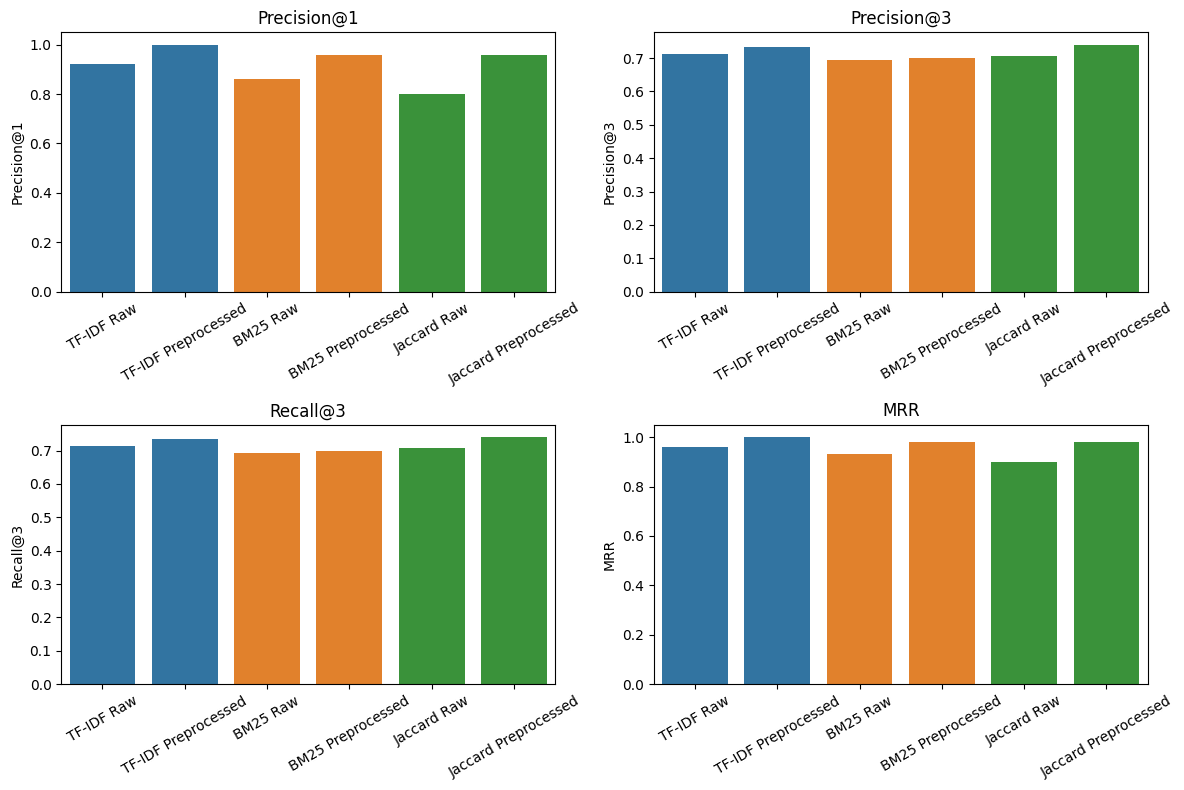

In [165]:
plot_metrics(traditional_ablation_results)

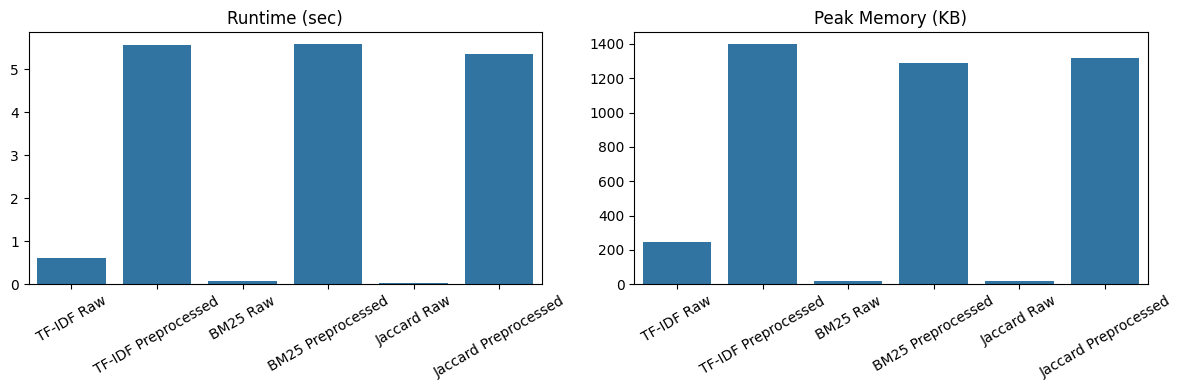

In [166]:
plot_runtime_memory(traditional_ablation_results)

### Speed-Accuracy Tradeoff curves

In [172]:
def plot_speed_accuracy_grid(results_dict, accuracy_metrics=None):
    if accuracy_metrics is None:
        accuracy_metrics = ["MRR", "Precision@1", "Precision@3", "Recall@3"]

    runtimes = [results["Runtime (in seconds)"] for results in results_dict.values()]
    labels = list(results_dict.keys())

    num_metrics = len(accuracy_metrics)
    rows = (num_metrics + 1) // 2

    fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows))
    axes = axes.flatten()

    for i, metric in enumerate(accuracy_metrics):
        accuracies = [results[metric] for results in results_dict.values()]

        sns.scatterplot(x=runtimes, y=accuracies, ax=axes[i])

        for j, label in enumerate(labels):
            axes[i].text(runtimes[j] + 0.01, accuracies[j], label, fontsize=9)

        axes[i].set_title(f"Speed-Accuracy Tradeoff ({metric})")
        axes[i].set_xlabel("Runtime (sec)")
        axes[i].set_ylabel(metric)
        axes[i].grid(True)

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


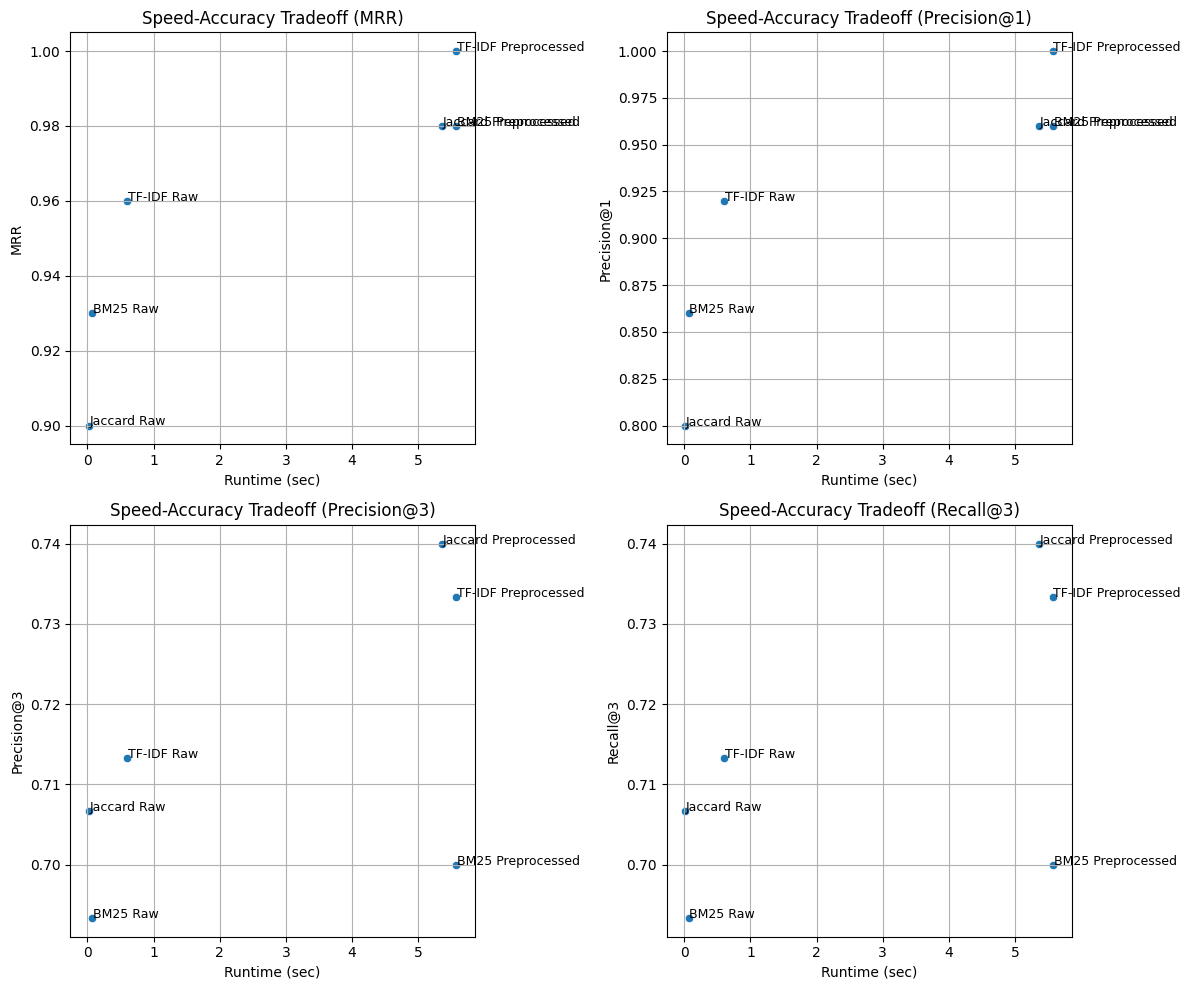

In [173]:
plot_speed_accuracy_grid(traditional_ablation_results)